In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from spectral_normalization import SpectralNorm
%matplotlib inline

In [2]:
transform = tfs.Compose([
    tfs.CenterCrop(512),
    tfs.RandomHorizontalFlip(0.5),
    tfs.Resize(128),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
PortraitSet = ImageFolder('./img_jpg', transform = transform)
PortraitData = DataLoader(PortraitSet, batch_size = 32, shuffle = True)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
real_batch = next(iter(PortraitData))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
class Generator_128(nn.Module):
    def __init__(self):
        super(Generator_128, self).__init__()
        self.deconv1 = nn.Sequential(
                        nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False),
                        nn.BatchNorm2d(64*8),
                        nn.ReLU(True))

        
        self.deconv2 = nn.Sequential(
                        nn.ConvTranspose2d(64*8, 64* 6, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*6),
                        nn.ReLU(True))
        
        
        self.deconv3 = nn.Sequential(
                        nn.ConvTranspose2d(64*6, 64*5, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*5),
                        nn.ReLU(True))
        
        
        self.deconv4 = nn.Sequential(
                        nn.ConvTranspose2d(64*5, 64*4, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*4),
                        nn.ReLU(True))
        
        
        self.deconv5 = nn.Sequential(
                        nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*2),
                        nn.ReLU(True))
        
        self.deconv6 = nn.Sequential(
                        nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64), 
                        nn.ReLU(True))
        
        
        self.skip_conv5 = nn.Sequential(
                            nn.Conv2d(64, 64, 3, 1, 1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(True))
        
        self.change_c_128 = nn.Sequential(
                        nn.Conv2d(64, 3, 1, 1),
                        nn.Tanh())
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x1 = self.deconv6(x)
        x2 = self.skip_conv5(x1)
        x1_rgb = self.change_c_128(x1)
        x2_rgb = self.change_c_128(x2)
        return torch.add(x1_rgb, x2_rgb)

In [6]:
class Discriminator_128(nn.Module):
    def __init__(self):
        super(Discriminator_128, self).__init__()
        self.conv1 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*16, 1, 4, 1, 0, bias = False)))
        
        
        self.conv2 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*8, 64*16, 4, 2, 1, bias = False)),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.conv3 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*6, 64*8, 4, 2, 1, bias = False)),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.conv4 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*5,64*6, 4, 2, 1, bias = False)),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.conv5 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*4, 64*5, 4, 2, 1, bias = False)),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.conv6 = nn.Sequential(
                    SpectralNorm(nn.Conv2d(64*2, 64*4, 4, 2, 1, bias = False)),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.skip_conv5 = nn.Sequential(
                        SpectralNorm(nn.Conv2d(64*2, 64*2, 3, 1, 1)),
                        nn.ReLU(True))
        
        
        self.change_c_128 = nn.Sequential(
                        SpectralNorm(nn.Conv2d(3, 64*2, 1, 1)),
                        nn.LeakyReLU(0.2, inplace=True))
    
    def forward(self, x):
        x1 = self.change_c_128(x)
        x1 = self.conv6(x1)
        x2 = self.change_c_128(x)
        x2 = self.skip_conv5(x2)
        x2 = self.conv6(x2)
        x = x1 + x2
        
        x = self.conv5(x)
        x = self.conv4(x)
        x = self.conv3(x)
        x = self.conv2(x)
        x = self.conv1(x)
        return x

In [7]:
G_net = Generator_128()
D_net = Discriminator_128()
G_net = nn.DataParallel(G_net)
D_net = nn.DataParallel(D_net)
G_net.to(device)
D_net.to(device)


G_optim = torch.optim.SGD(G_net.parameters(), lr = 0.00001)
D_optim = torch.optim.SGD(D_net.parameters(), lr = 0.00004)

In [8]:
G_net_128_pre = torch.load('Generator_128_a_20.pkl')
G_net.load_state_dict(G_net_128_pre)
D_net_128_pre = torch.load('Discriminator_128_a_20.pkl')
D_net.load_state_dict(D_net_128_pre)

In [9]:
criterion = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 0.9
fake_label = 0
epoch = 10

In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epo in range(epoch):
    for i, data in enumerate(PortraitData, 0):
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device = device)
        output = D_net(real_data).view(-1)
        real_error = criterion(output, label)
        D_optim.zero_grad()
        real_error.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, 100, 1, 1,device = device)
        fake_data = G_net(noise)
        label.fill_(fake_label)
        output = D_net(fake_data.detach()).view(-1)
        fake_error = criterion(output, label)
        fake_error.backward()
        D_G_z1 = output.mean().item()
        err_D = real_error + fake_error
        D_optim.step()
        
        label.fill_(real_label)
        output = D_net(fake_data).view(-1)
        err_G = criterion(output, label)
        G_optim.zero_grad()
        err_G.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epo, epoch, i, len(PortraitData),
                     err_D.item(), err_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epo == epoch-1) and (i == len(PortraitData)-1)):
            with torch.no_grad():
                fake = G_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1        

[0/10][0/1076]	Loss_D: 0.7761	Loss_G: 1.5966	D(x): 0.7833	D(G(z)): -1.5300 / -1.4944
[0/10][50/1076]	Loss_D: 0.7194	Loss_G: 1.6185	D(x): 0.9130	D(G(z)): -1.5079 / -1.5486
[0/10][100/1076]	Loss_D: 0.8367	Loss_G: 1.5637	D(x): 0.5277	D(G(z)): -1.6903 / -1.4486
[0/10][150/1076]	Loss_D: 0.7732	Loss_G: 1.5638	D(x): 0.8104	D(G(z)): -1.3904 / -1.4362
[0/10][200/1076]	Loss_D: 0.8739	Loss_G: 1.5094	D(x): 0.8864	D(G(z)): -1.2015 / -1.3516
[0/10][250/1076]	Loss_D: 0.8231	Loss_G: 1.5880	D(x): 0.7511	D(G(z)): -1.4278 / -1.4881
[0/10][300/1076]	Loss_D: 0.8488	Loss_G: 1.4919	D(x): 0.8293	D(G(z)): -1.3518 / -1.3268
[0/10][350/1076]	Loss_D: 0.8358	Loss_G: 1.7014	D(x): 0.5349	D(G(z)): -1.8340 / -1.6242
[0/10][400/1076]	Loss_D: 0.7970	Loss_G: 1.7142	D(x): 0.6837	D(G(z)): -1.7054 / -1.6354
[0/10][450/1076]	Loss_D: 0.8229	Loss_G: 1.5250	D(x): 1.0545	D(G(z)): -1.2706 / -1.4014
[0/10][500/1076]	Loss_D: 0.8662	Loss_G: 1.4795	D(x): 0.7417	D(G(z)): -1.3531 / -1.3189
[0/10][550/1076]	Loss_D: 0.7298	Loss_G: 1.6568

[4/10][350/1076]	Loss_D: 0.6799	Loss_G: 1.7548	D(x): 1.1289	D(G(z)): -1.6857 / -1.7198
[4/10][400/1076]	Loss_D: 0.7741	Loss_G: 1.6210	D(x): 0.8110	D(G(z)): -1.4526 / -1.5295
[4/10][450/1076]	Loss_D: 0.7542	Loss_G: 1.6121	D(x): 0.9043	D(G(z)): -1.4641 / -1.5260
[4/10][500/1076]	Loss_D: 0.7655	Loss_G: 1.5954	D(x): 0.6900	D(G(z)): -1.6004 / -1.5087
[4/10][550/1076]	Loss_D: 0.8914	Loss_G: 1.4072	D(x): 0.7736	D(G(z)): -1.1507 / -1.2368
[4/10][600/1076]	Loss_D: 0.9911	Loss_G: 1.3242	D(x): 0.3332	D(G(z)): -1.1067 / -1.0907
[4/10][650/1076]	Loss_D: 0.7699	Loss_G: 1.6335	D(x): 0.9725	D(G(z)): -1.4178 / -1.5284
[4/10][700/1076]	Loss_D: 0.8175	Loss_G: 1.5749	D(x): 0.7292	D(G(z)): -1.4360 / -1.4500
[4/10][750/1076]	Loss_D: 0.6844	Loss_G: 1.6886	D(x): 1.3097	D(G(z)): -1.5230 / -1.6499
[4/10][800/1076]	Loss_D: 0.7539	Loss_G: 1.7832	D(x): 0.9322	D(G(z)): -1.8040 / -1.7391
[4/10][850/1076]	Loss_D: 0.7852	Loss_G: 1.6081	D(x): 0.6987	D(G(z)): -1.5254 / -1.5307
[4/10][900/1076]	Loss_D: 0.8130	Loss_G: 1.5

[8/10][700/1076]	Loss_D: 0.8835	Loss_G: 1.5240	D(x): 0.7946	D(G(z)): -1.2629 / -1.3772
[8/10][750/1076]	Loss_D: 0.7993	Loss_G: 1.5685	D(x): 1.1607	D(G(z)): -1.2800 / -1.4591
[8/10][800/1076]	Loss_D: 0.7339	Loss_G: 1.7649	D(x): 0.8853	D(G(z)): -1.6752 / -1.7083
[8/10][850/1076]	Loss_D: 0.7330	Loss_G: 1.7589	D(x): 0.9721	D(G(z)): -1.6369 / -1.6933
[8/10][900/1076]	Loss_D: 0.7049	Loss_G: 1.6582	D(x): 1.4495	D(G(z)): -1.3867 / -1.5982
[8/10][950/1076]	Loss_D: 0.8627	Loss_G: 1.5359	D(x): 0.8816	D(G(z)): -1.4264 / -1.4074
[8/10][1000/1076]	Loss_D: 0.7727	Loss_G: 1.7372	D(x): 1.2184	D(G(z)): -1.4097 / -1.6448
[8/10][1050/1076]	Loss_D: 0.7550	Loss_G: 1.6756	D(x): 1.2912	D(G(z)): -1.3377 / -1.5893
[9/10][0/1076]	Loss_D: 0.7880	Loss_G: 1.6258	D(x): 0.8203	D(G(z)): -1.6831 / -1.5599
[9/10][50/1076]	Loss_D: 0.8284	Loss_G: 1.5640	D(x): 0.6186	D(G(z)): -1.6117 / -1.4392
[9/10][100/1076]	Loss_D: 0.8852	Loss_G: 1.4661	D(x): 0.5761	D(G(z)): -1.4214 / -1.3236
[9/10][150/1076]	Loss_D: 0.7651	Loss_G: 1.62

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

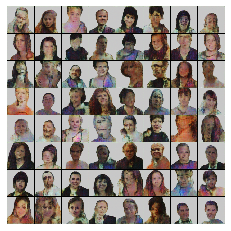

In [11]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [12]:
torch.save(G_net.state_dict(), 'Generator_128_a_21.pkl')
torch.save(D_net.state_dict(), 'Discriminator_128_a_21.pkl')